In [1]:
%matplotlib notebook
from ipynb.fs.defs.utilities import *

In [2]:
#Customized color bar 1

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(70/256, 177/256, N)
vals[:, 1] = np.linspace(130/256, 78/256, N)
vals[:, 2] = np.linspace(180/256, 132/256, N)
newcmp = ListedColormap(vals)

#Customized color bar 2

vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [214, 244, 255]
col3 = [227, 158, 33]
 

vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2))

cmp_blue_3col = ListedColormap(vals)
cmp_blue_3col_inv = ListedColormap(cmp_blue_3col.colors[::-1])

# Workspace and analysis of the CardioMag eMNS

Demonstration of the concepts and tools for the analysis of the CardioMag eMNS developped by Aeon Scientific. The CardioMag is an eight-coil preclinical prototype used for cardiac catheter steering. 

In [3]:
# Load system calibration
cal_path_cmag = os.path.join('models/C_Mag_Calibration_06-25-2015_no_offset.yaml')

model_cmag = ForwardModelMPEM()
model_cmag.setCalibrationFile(cal_path_cmag)

In [4]:
def ComputeMaxFieldWithZeroGradDicho(Nx,Ny,Nz,pmin,pmax,bmax,eps,Imin,Imax,model_mns):

    p_ws = np.empty((0,3))
    max_field_mT = np.array([])

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True) 


    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):
                
                                
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                J = model_mns.getActuationMatrix(position)

                #Check feasibility at each grid point            
                N, d = HyperPlaneShiftingMethod(J,Imin,Imax)
  
                
                tresh_max = bmax
                tresh_min = 0.
                btest = (tresh_max + tresh_min)/2
                
                while((tresh_max - tresh_min) >= eps):
                    btest = (tresh_max + tresh_min)/2
                    a = np.array([btest, btest, btest, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10])
                    isFeasible = VerifyFeasabilityEllipsoid(d,N,a)
                    
                    if isFeasible:
                        tresh_min = btest
                    else:
                        tresh_max = btest
                

                
                p_ws = np.append(p_ws, [position], axis=0)
                max_field_mT = np.append(max_field_mT, [btest*1000], axis=0)
                
      
    return p_ws, max_field_mT

In [5]:
#Define inputs interval and task set
Imin = -20
Imax = 20

eps = 0.00005

In [6]:
#Define requirements for catheter steering

Br = 1.3 #magnet remanence [T]
l = 5.0e-3 #magnet length [m]
d = 2.33e-3 #outer diameter [m]
mu0 = 4*math.pi*(10**(-7)) # permeability of vacuum [H/m]
m = (math.pi*(d/2)**2*l*Br)/mu0 #magnetic dipole moment [Nm/T]

theta_des = 120 * math.pi/180 # desired max tip angle [rad]
L = 4.0e-2 #length of the catheter [m]
E = 15.0e6 #Young's modulus of the catheter [Pa]
I = math.pi * (d/2)**4 /4 #second moment of area of the cross-section [m^4]

#Compute maximum torque and field magnitude
tmax = theta_des * E * I / L #[N.m]
bmax = tmax / m #[T]

print(tmax)
print(bmax)

0.001136275033022366
0.051520283974109654


In [7]:
#Horizontal plane
Nx = 100
Ny = 100
Nz = 1

bmax_dicho = 0.12
p0 = np.array([-0.00851678, 0.03142507, 0.03213744]) #center of the mns frame (translation to center of the world frame)
poff = np.array([0., 0., 0.008]) #offset above patient bed

#Build initial box
pmin_hor = np.array([-0.15,-0.15,0.]) - p0 + poff
pmax_hor = np.array([0.15,0.15,0.]) - p0 + poff

p_hor, max_field_hor = ComputeMaxFieldWithZeroGradDicho(Nx,Ny,Nz,pmin_hor,pmax_hor,bmax_dicho,eps,Imin,Imax,model_cmag)

x_hor = np.linspace(pmin_hor[0], pmax_hor[0], 70, endpoint=True)
y_hor = np.linspace(pmin_hor[1], pmax_hor[1], 70, endpoint=True)
z_hor = griddata((p_hor[:,0], p_hor[:,1]), max_field_hor/1000, (x_hor[None,:], y_hor[:,None]), method='linear')

In [8]:
p_ws_3_bg_x_in, p_ws_3_bg_x_out, p_ws_3_bg_x_side, kappa_3_bg_x, mu_3_bg_x, gci_3_bg_x, ad_3_bg_x = Ws3DFieldGradientDeterminationDiscr(Nx,Ny,Nz,pmin_hor,pmax_hor,-bmax,bmax,-1.e-10,1.e-10,-20,20,model_cmag,'ellipsoid')

<IPython.core.display.Javascript object>


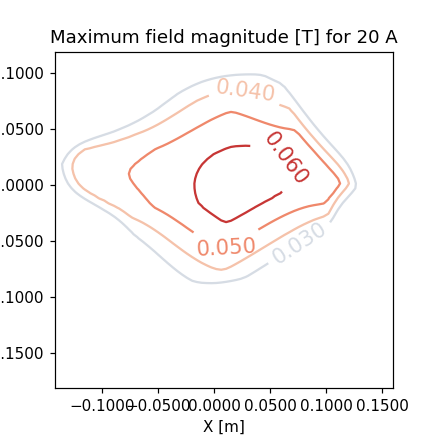

In [9]:
fig = plt.figure(figsize=(4, 4))

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor, [0.03, 0.04, 0.05, 0.06], cmap=cm.coolwarm, alpha=1., vmin=max_field_hor.min()/1000, vmax=max_field_hor.max()/1000)
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.3f')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('Maximum field magnitude [T] for 20 A')
ax.axis('equal')

plt.show()

<IPython.core.display.Javascript object>


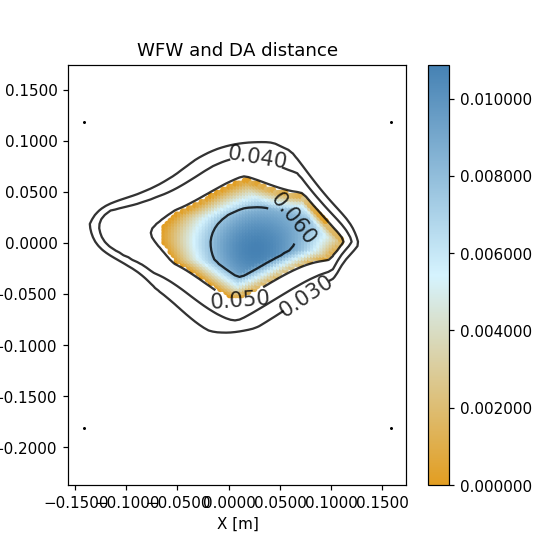

In [10]:
fig = plt.figure(figsize=(5, 5))

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor, [0.03, 0.04, 0.05, 0.06], alpha=0.8, colors='black', vmin=max_field_hor.min()/1000, vmax=max_field_hor.max()/1000)
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.3f')

s = ax.scatter(p_ws_3_bg_x_in[:,0],p_ws_3_bg_x_in[:,1],alpha=1., s = 10, c=ad_3_bg_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_bg_x.max())
ax.scatter(p_ws_3_bg_x_side[:,0],p_ws_3_bg_x_side[:,1], color='black',alpha=1., s = 1., rasterized=True)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('WFW and DA distance')
ax.axis('equal')

plt.colorbar(s)
plt.show()